# 0. Import libraries
## 0.1. Import public libraries

In [1]:
import os
import sys

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns


This notebook was made with celloracle version 0.10.5.
**Please use celloracle>=0.10.1** Otherwise, you may get an error.

In [2]:
import celloracle as co
co.__version__

'0.10.12'

In [3]:
#plt.rcParams["font.family"] = "arial"
plt.rcParams["figure.figsize"] = [6,6]
%config InlineBackend.figure_format = 'retina'
plt.rcParams["savefig.dpi"] = 600

%matplotlib inline

## 0.1. Make a folder to save graph

In [4]:
# Make folder to save plots
save_folder = "figures"
os.makedirs(save_folder, exist_ok=True)

# 1. Load data
## 1.1. Load processed oracle object

Load the oracle object. See the previous notebook for information on initializing an `Oracle` object.

In [5]:
oracle = co.load_hdf5("./Myeloid.celloracle.oracle")

## 1.2. Load inferred GRNs

In the previous notebook, we calculated the GRNs. Now, we will use these GRNs for the perturbation simulations. First, we will import the GRNs from the `Links` object.

In [6]:
links = co.load_hdf5("./links_myeloid_RNA_snn_res.0.5.celloracle.links")

# 2. Make predictive models for simulation

Here, we will need to fit the ridge regression models again. This process will take less time than the GRN inference in the previous notebook, because we are using the filtered GRN models.

In [7]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, 
                              use_cluster_specific_TFdict=True)

  0%|          | 0/11 [00:00<?, ?it/s]

# 3. In silico TF perturbation analysis

Next, we will simulate the TF perturbation effects on cell identity to investigate its potential functions and regulatory mechanisms. Please see the CellOracle paper for more details on scientific rationale.

In this notebook, we will simulate the knockout of the Gata1 gene in the hematopoiesis trajectory.

Previous studies have shown that Gata1 is one of the TFs that regulates cell fate decisions in myeloid progenitors. Additionally, Gata1 has been shown to affect erythroid cell differentiation.

Here, we will use CellOracle to analyze Gata1 and attempt to recapitulate the previous findings from above.


## 3.1. Check gene expression pattern.

In [8]:
# Check gene expression 
goi = "Brd4"
sc.pl.umap(oracle.adata, color=[goi, oracle.cluster_column_name], s=30,
                 layer="imputed_count", use_raw=False, cmap="viridis")

KeyError: 'Could not find key Brd4 in .var_names or .obs.columns.'

<Figure size 1374x600 with 0 Axes>

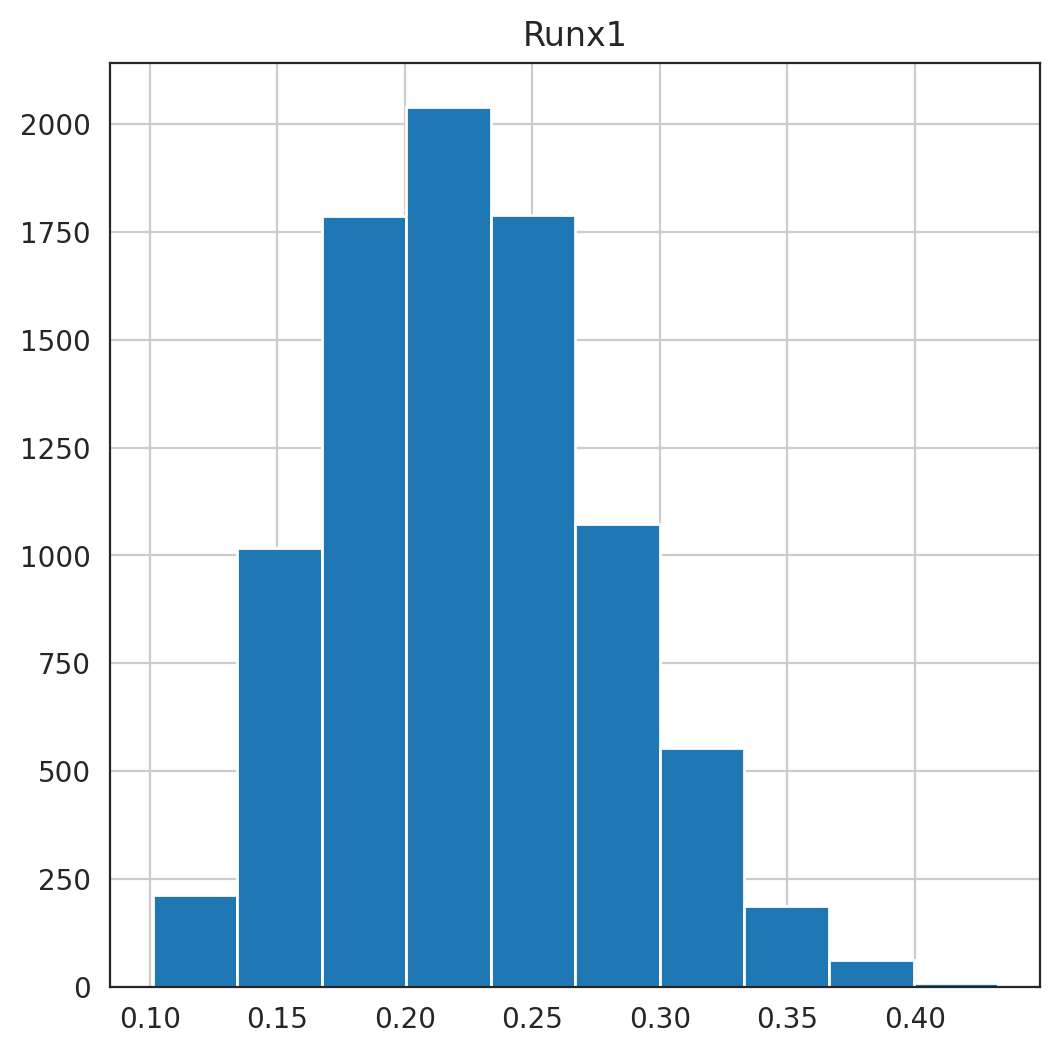

In [9]:
# Plot gene expression in histogram
sc.get.obs_df(oracle.adata, keys=[goi], layer="imputed_count").hist()
plt.show()

## 3.2. Calculate future gene expression after perturbation.

- You can use any gene expression value in the in silico perturbations, but please avoid extremely high values that are far from the natural gene expression range. The upper limit allowed is twice the maximum gene expression.


To simulate Gata1 KO, we will set Gata1 expression to 0.

In [10]:
# Enter perturbation conditions to simulate signal propagation after the perturbation.
oracle.simulate_shift(perturb_condition={goi: 0.0},
                      n_propagation=3)

In [11]:
#oracle.evaluate_simulated_gene_distribution_range()

## 3.3. Calculate transition probability between cells

- The steps above simulated tge global future gene expression shift after perturbation. This prediction is based on iterative calculations of signal propagation calculations within the GRN. Please look at our paper for more information.

- The next step calculates the probability of cell state transitions based on the simulation data. You can use the transition probabilities between cells to predict how cells will change after a perturbation.

- This transition probability will be used later.


In [12]:
# Get transition probability
oracle.estimate_transition_prob(n_neighbors=200,
                                knn_random=True, 
                                sampled_fraction=0.2)

# Calculate embedding 
oracle.calculate_embedding_shift(sigma_corr=0.05)

# 4. Visualization
## 4.1. Quiver plot: Show the direction of cell transition at single cell resolution

### Caution: It is very important to find the optimal `scale` parameter.

- We will need to adjust the `scale` parameter. Please seek to find the optimal `scale` parameter for the data based on your data.

- If the vectors are not visible, you can try a smaller `scale` parameter to magnify the vector length. However, if you see large vectors in the randomized results (right panel), it means that the scale parameter is too small.


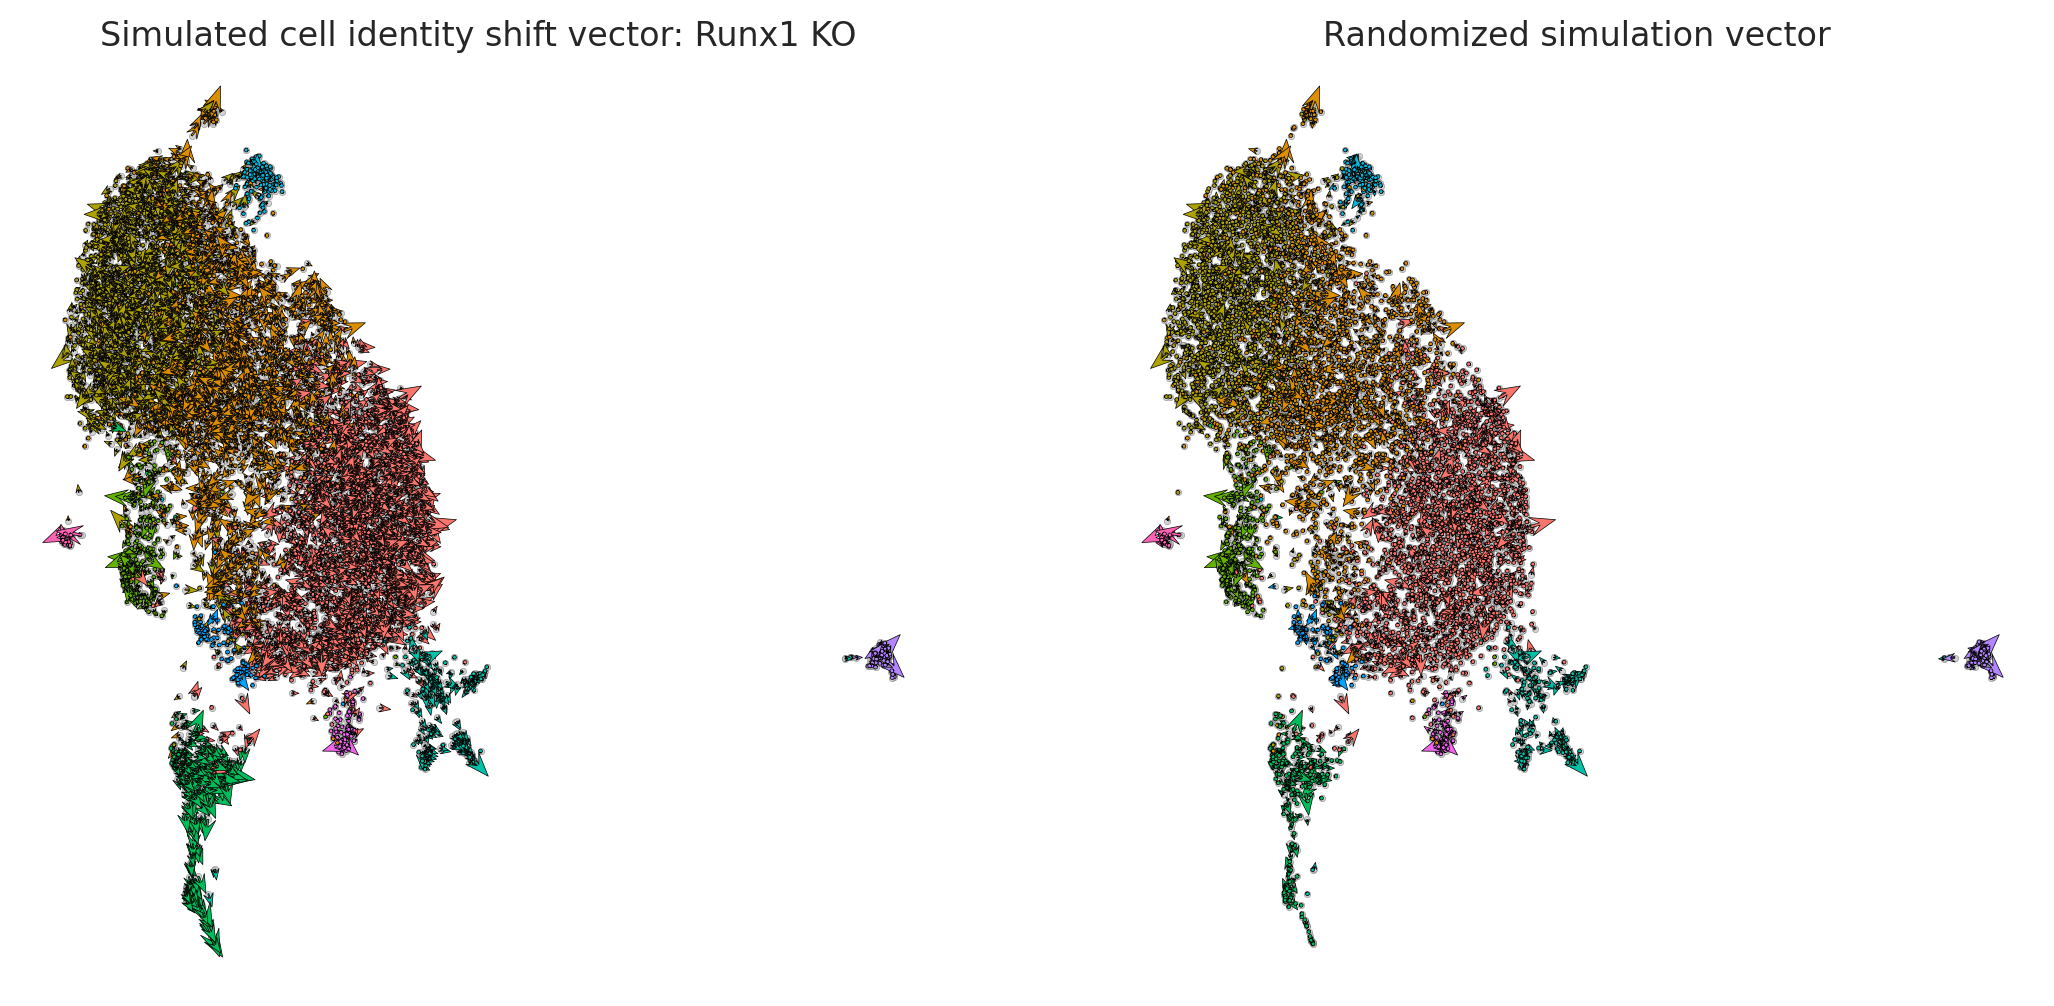

In [39]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale = 60
# Show quiver plot
oracle.plot_quiver(scale=scale, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_quiver_random(scale=scale, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

## 4.2. Vector field graph

We will visualize the simulation results as a vector field on a digitized grid. Single cell transition vectors are grouped by grid point.

### 4.2.1  Find parameters for n_grid and min_mass
`n_grid`: Number of grid points.

`min_mass`: Threshold value for the cell density. 
The appropriate values for these parameters depends on the data. Please find appropriate values using the helper functions below.
 


In [15]:
# n_grid = 40 is a good starting value.
n_grid = 40 
oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)

Please run `oracle.suggest_mass_thresholds()` to display a range of `min_mass` parameter values and choose a value to fit the data.

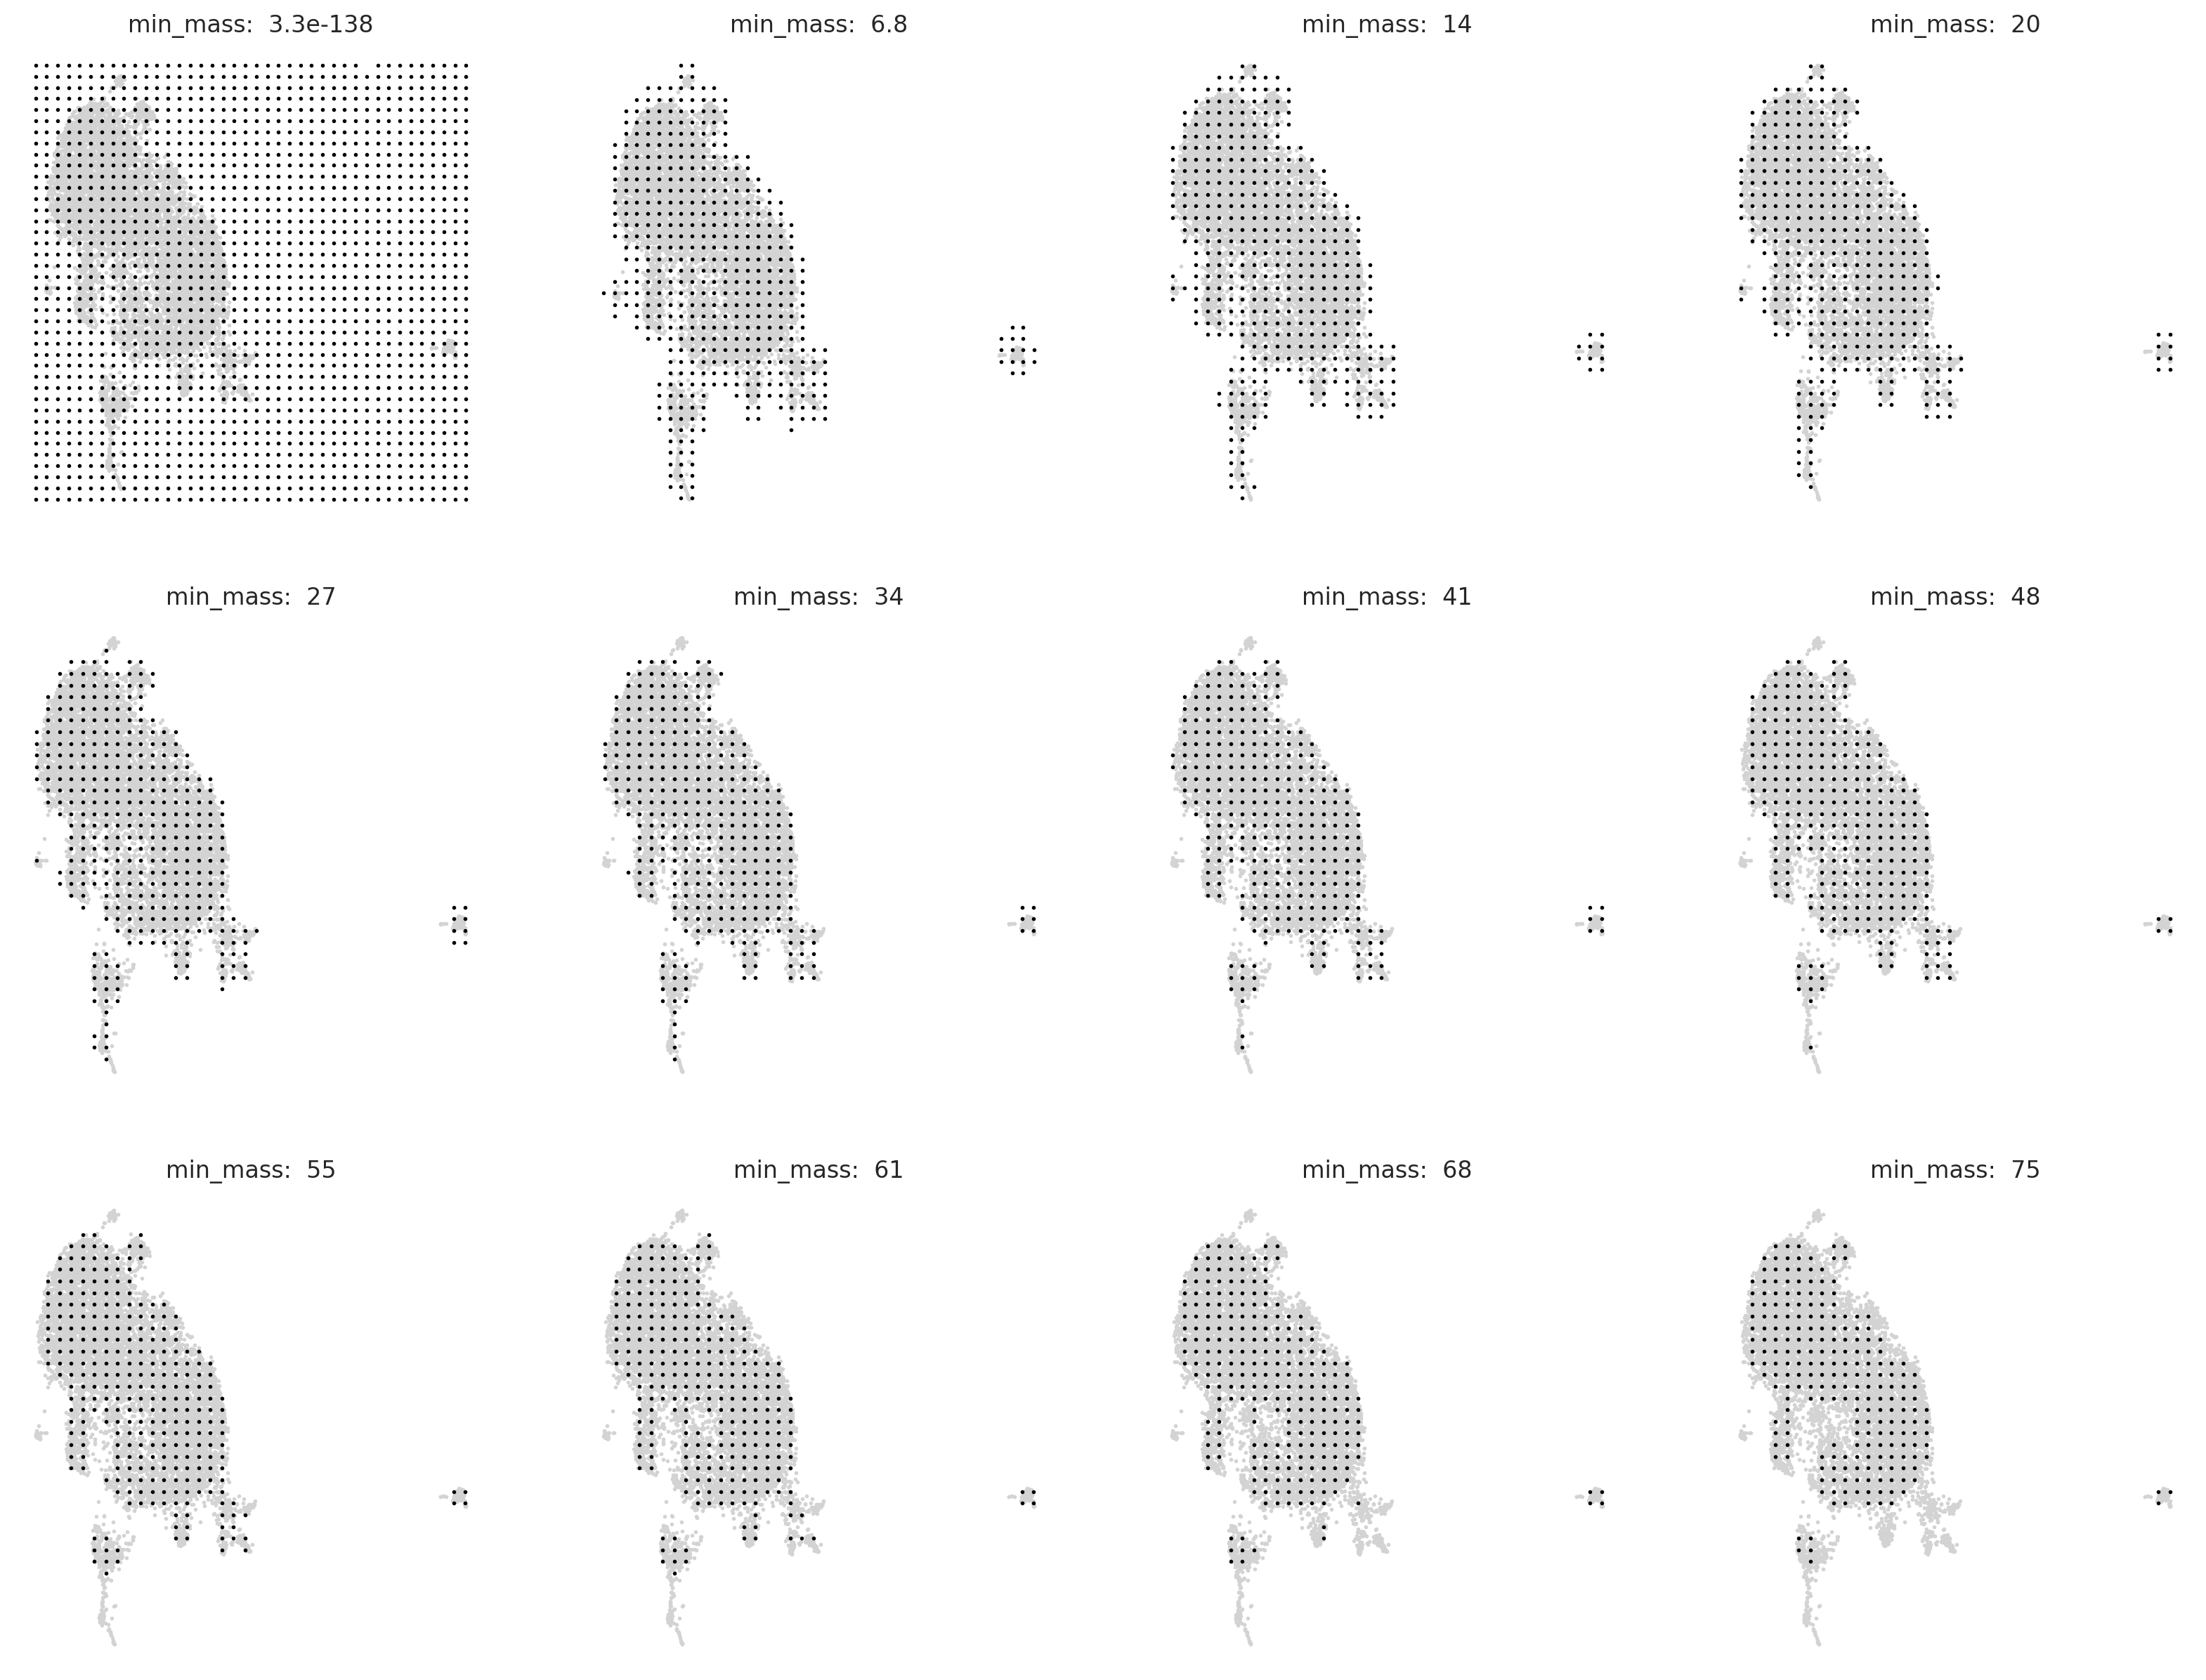

In [16]:
# Search for best min_mass.
oracle.suggest_mass_thresholds(n_suggestion=12)

According to the results, the optimal `min_mass` is around 0.011.

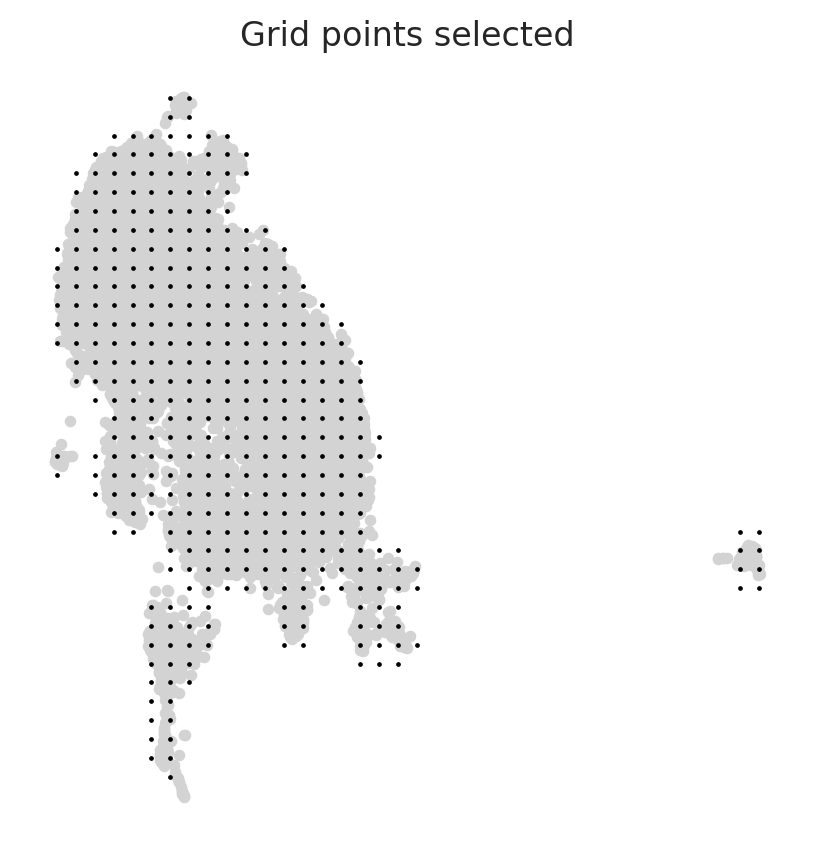

In [17]:
min_mass = 20
oracle.calculate_mass_filter(min_mass=min_mass, plot=True)

### 4.2.2  Plot vector fields

- Again, we need to adjust the `scale` parameter. Please seek to find the optimal `scale` parameter that provides good visualization.

- If you don't see any vector, you can try the smaller `scale` parameter to magnify the vector length. However, if you see large vectors in the randomized results (right panel), it means the scale parameter is too small.



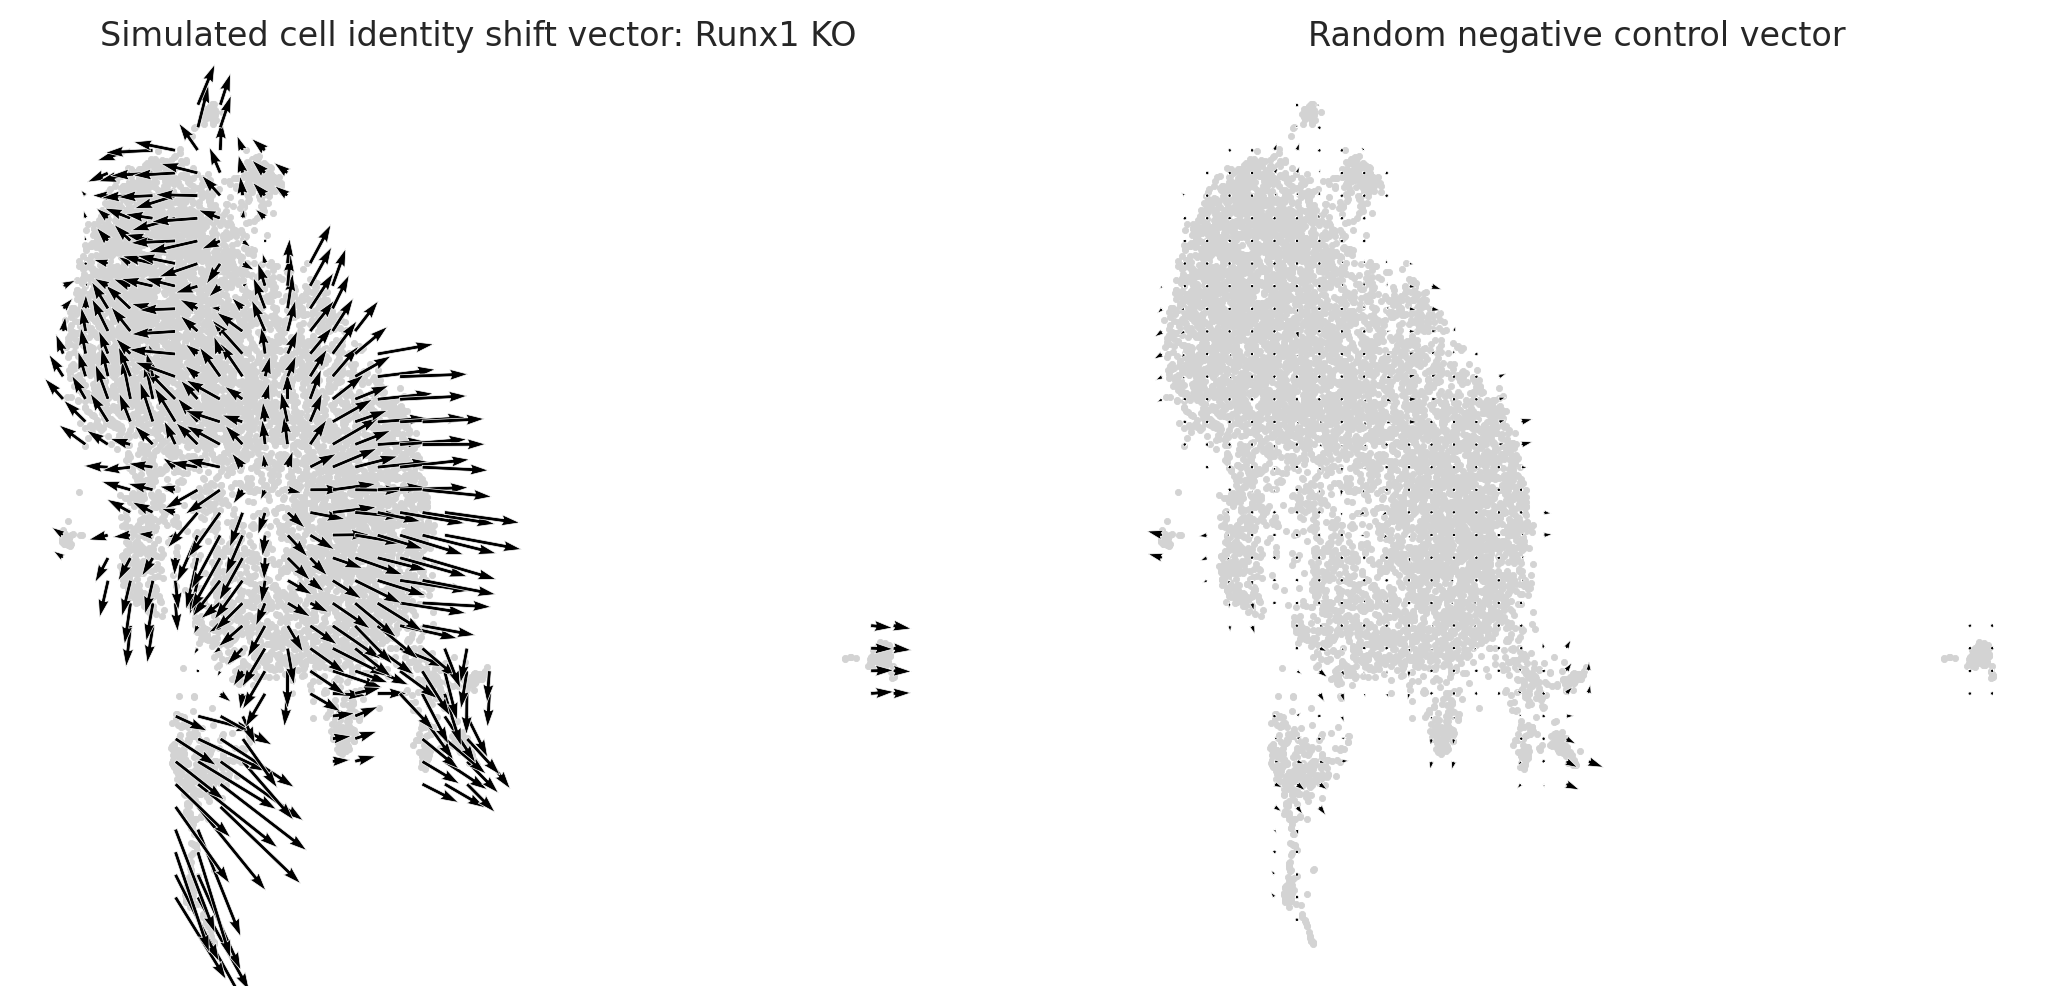

In [18]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale_simulation = 7
# Show quiver plot
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
ax[1].set_title(f"Random negative control vector")

plt.savefig("RUNX1_KO_simulation_vector_field.pdf")

plt.show()

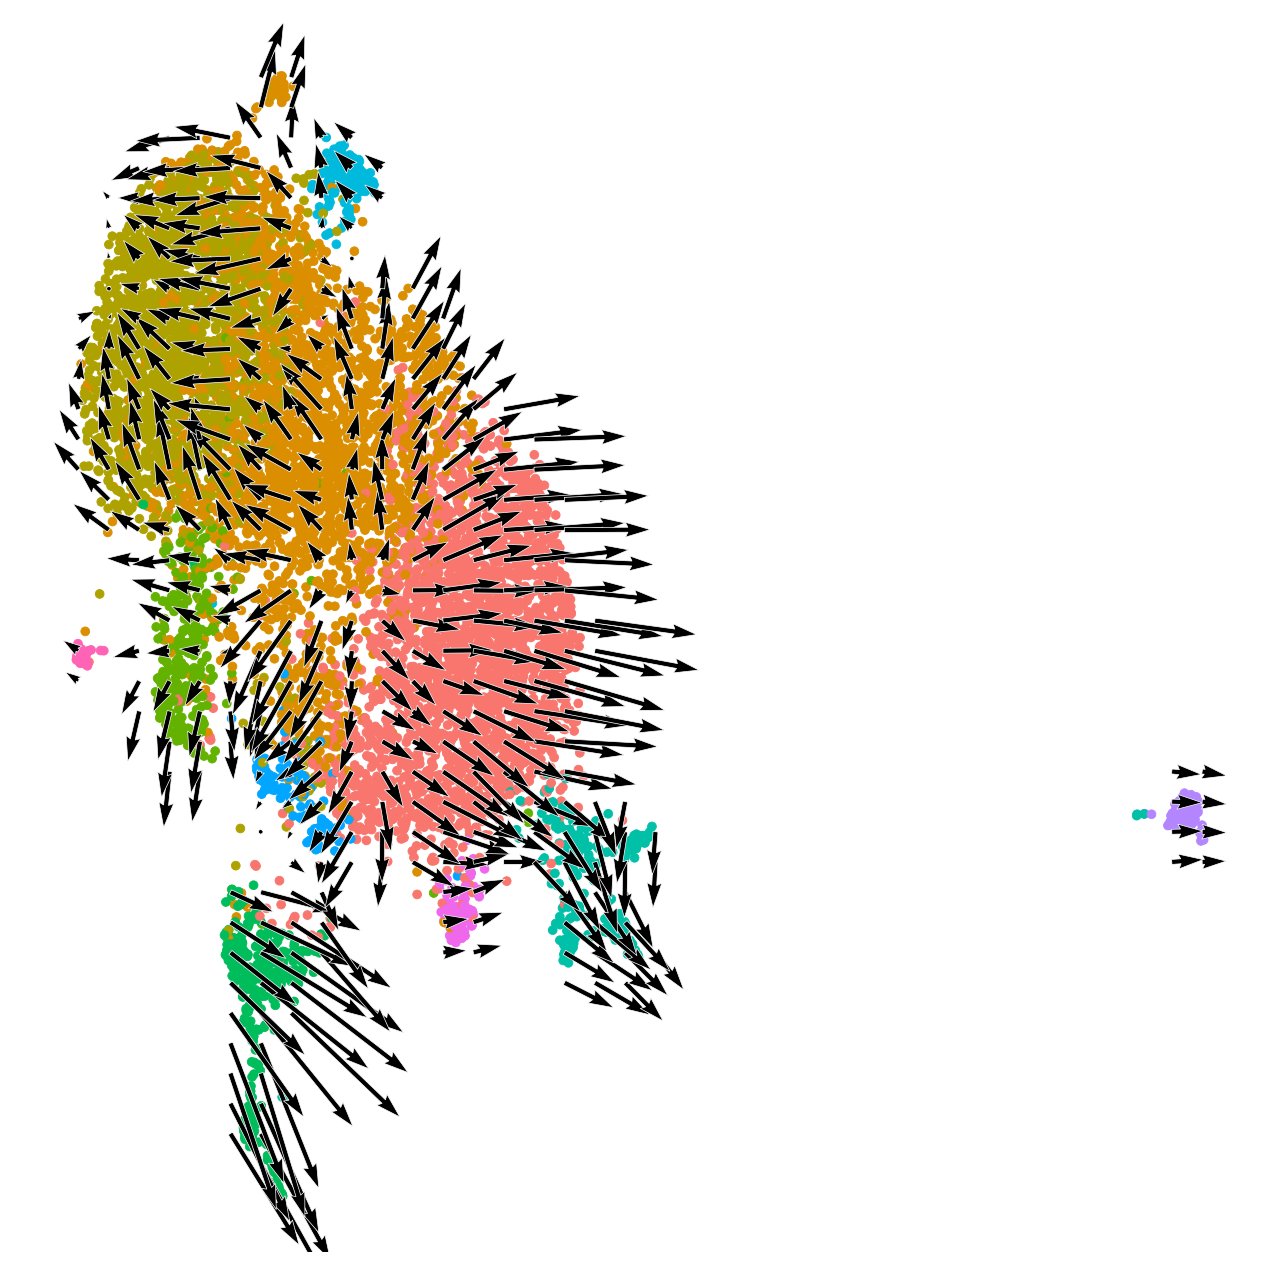

In [19]:
# Plot vector field with cell cluster 
fig, ax = plt.subplots(figsize=[8, 8])

oracle.plot_cluster_whole(ax=ax, s=10)
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax, show_background=False)

plt.savefig("RUNX1_KO_simulation_vector_field_on_cluster_color.pdf")

In [18]:
adata = oracle.adata

In [20]:
adata

AnnData object with n_obs × n_vars = 20000 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.3', 'seurat_clusters', 'cell.type', 'condition', 'RNA_snn_res.0.2', 'RNA_snn_res.0.3', 'RNA_snn_res.0.4', 'RNA_snn_res.0.5', 'RNA_snn_res.0.6', 'Fibro_z', 'Pericyte_z', 'SMC_z', 'SCT_snn_res.0.1', 'SCT_snn_res.0.2', 'SCT_snn_res.0.4', 'SCT_snn_res.0.5', 'active_ident', 'condition_and_celltype', 'umap_density_condition', 'n_counts'
    var: 'variable_gene', 'symbol', 'isin_top1000_var_mean_genes', 'isin_TFdict_targets', 'isin_TFdict_regulators', 'isin_actve_regulators'
    uns: 'RNA_snn_res.0.4_colors', 'active_ident_colors', 'seurat_clusters_colors', 'cell.type_colors', 'condition_colors', 'umap_density_condition_params', 'log1p'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    layers: 'raw_count', 'normalized_count', 'imputed_count', 'simulation_input', 'simulated_count', 'de

In [24]:
import palantir

# Plotting and miscellaneous imports
import os
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [22]:
sc.pp.normalize_per_cell(adata)

In [1]:
sc.pp.highly_variable_genes(adata, n_top_genes=1500, flavor='seurat')

NameError: name 'sc' is not defined

In [24]:
sc.pp.pca(adata)

In [25]:
# Run diffusion maps
pca_projections = pd.DataFrame(adata.obsm['X_pca'], index=adata.obs_names)
dm_res = palantir.utils.run_diffusion_maps(pca_projections)

Determing nearest neighbor graph...


In [28]:
ms_data = palantir.utils.determine_multiscale_space(dm_res, n_eigs=5)
ms_data

0         1         2         3
TWCM-463-R-post_TACTTGTCAGGACCCT  -0.124107  0.133335  0.015696  0.015182
TWCM-11-78_GTCATTTGTCCAGTAT        0.133374  0.032570 -0.006776  0.024431
TWCM-229-R-pre_TGACGGCCAAGCCTAT   -0.028441 -0.020371 -0.065017  0.018293
TWCM-13-80_TAGTGGTCAGCTTCGG        0.206383  0.041305  0.018875  0.023438
TWCM-463-R-post_CCTACCACACCCAGTG  -0.163218  0.054975  0.038780 -0.045724
...                                     ...       ...       ...       ...
TWCM-410-NR-post_GGGAGATCATCAGTAC -0.091187 -0.051335 -0.072619 -0.006229
TWCM-388-NR-post_TCACAAGTCATTGCGA -0.119615 -0.133156 -0.013644  0.050823
TWCM-11-78_CTAGCCTTCACCTCGT        0.177774  0.052428  0.005880  0.033742
TWCM-14-173_GAGGTGAAGCCGCCTA       0.272284 -0.033495  0.025135 -0.049984
TWCM-229-R-post_AAGGTTCTCCATGCTC  -0.098589  0.137205  0.024077  0.020282

[20000 rows x 4 columns]

In [29]:
adata.layers['MAGIC_imputed_data'] = palantir.utils.run_magic_imputation(adata, dm_res)

In [34]:
adata.obs[adata.obs['cell.type'] == 'Fib1']

orig.ident  nCount_RNA  nFeature_RNA  \
TWCM-463-R-post_TACTTGTCAGGACCCT    TWCM-463-R-post        2126          1316   
TWCM-229-R-pre_TGACGGCCAAGCCTAT      TWCM-229-R-pre        1280           927   
TWCM-13-80_TAGTGGTCAGCTTCGG              TWCM-13-80        2076          1290   
TWCM-363-NR-pre_TGGCTGGGTCAGGACA    TWCM-363-NR-pre        1168           799   
TWCM-229-R-pre_CGTTAGACATGGTTGT      TWCM-229-R-pre        1724          1223   
...                                             ...         ...           ...   
TWCM-296-R-post_ATTGGACGTGGCTCCA    TWCM-296-R-post        1783          1115   
TWCM-388-NR-post_TTTCCTCAGTCACGCC  TWCM-388-NR-post        1181           898   
H_ZC-11-292_CCTTACGAGAAACCGC            H_ZC-11-292        1836          1151   
TWCM-410-NR-post_GGGAGATCATCAGTAC  TWCM-410-NR-post        1261           875   
TWCM-11-78_CTAGCCTTCACCTCGT              TWCM-11-78        2817          1631   

                                   percent.mt  scrublet_score  \
TWCM-463-R-post_TACTTGTCAGGACCCT     0.376294        0.043103   
TWCM-229-R-pre_TGACGGCCAAGCCTAT      0.625000        0.028446   
TWCM-13-80_TAGTGGTCAGCTTCGG          0.337187        0.032836   
TWCM-363-NR-pre_TGGCTGGGTCAGGACA     0.599315        0.021322   
TWCM-229-R-pre_CGTTAGACATGGTTGT      0.754060        0.095361   
...                                       ...             ...   
TWCM-296-R-post_ATTGGACGTGGCTCCA     0.280426        0.042230   
TWCM-388-NR-post_TTTCCTCAGTCACGCC    0.169348        0.048458   
H_ZC-11-292_CCTTACGAGAAACCGC         0.054466        0.017288   
TWCM-410-NR-post_GGGAGATCATCAGTAC    0.396511        0.051282   
TWCM-11-78_CTAGCCTTCACCTCGT          0.070998        0.028546   

                                   scrublet_cluster_score   bh_pval  \
TWCM-463-R-post_TACTTGTCAGGACCCT                 0.043734  0.910667   
TWCM-229-R-pre_TGACGGCCAAGCCTAT                  0.021940  0.816360   
TWCM-13-80_TAGTGGTCAGCTTCGG                      0.030568  0.777945   
TWCM-363-NR-pre_TGGCTGGGTCAGGACA                 0.034913  0.678694   
TWCM-229-R-pre_CGTTAGACATGGTTGT                  0.026335  0.816360   
...                                                   ...       ...   
TWCM-296-R-post_ATTGGACGTGGCTCCA                 0.053521  0.858226   
TWCM-388-NR-post_TTTCCTCAGTCACGCC                0.059538  0.811791   
H_ZC-11-292_CCTTACGAGAAACCGC                     0.032048  0.954270   
TWCM-410-NR-post_GGGAGATCATCAGTAC                0.046809  0.805372   
TWCM-11-78_CTAGCCTTCACCTCGT                      0.029891  0.778198   

                                   nCount_SCT  nFeature_SCT SCT_snn_res.0.3  \
TWCM-463-R-post_TACTTGTCAGGACCCT         2120          1316               0   
TWCM-229-R-pre_TGACGGCCAAGCCTAT          1587           927               0   
TWCM-13-80_TAGTGGTCAGCTTCGG              2070          1290               0   
TWCM-363-NR-pre_TGGCTGGGTCAGGACA         1554           800               0   
TWCM-229-R-pre_CGTTAGACATGGTTGT          1796          1223               0   
...                                       ...           ...             ...   
TWCM-296-R-post_ATTGGACGTGGCTCCA         1840          1115               0   
TWCM-388-NR-post_TTTCCTCAGTCACGCC        1524           898               0   
H_ZC-11-292_CCTTACGAGAAACCGC             1887          1151               0   
TWCM-410-NR-post_GGGAGATCATCAGTAC        1658           875               0   
TWCM-11-78_CTAGCCTTCACCTCGT              2479          1631               0   

                                   ... Pericyte_z     SMC_z SCT_snn_res.0.1  \
TWCM-463-R-post_TACTTGTCAGGACCCT   ...  -0.612416 -0.426015               0   
TWCM-229-R-pre_TGACGGCCAAGCCTAT    ...  -0.189580 -0.426015               0   
TWCM-13-80_TAGTGGTCAGCTTCGG        ...  -0.347548 -0.426015               0   
TWCM-363-NR-pre_TGGCTGGGTCAGGACA   ...  -0.612416 -0.426015               0   
TWCM-229-R-pre_CGTTAGACATGGTTGT    ...  -0.324049 -0.426015               0   
...        

In [35]:
start_cell = 'TWCM-463-R-post_TACTTGTCAGGACCCT'
pr_res = palantir.core.run_palantir(ms_data, start_cell, num_waypoints=600)

Sampling and flocking waypoints...
Time for determining waypoints: 0.02301265001296997 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...


findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found.

Time for shortest paths: 0.5156497836112977 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9959
Correlation at iteration 2: 0.9997
Correlation at iteration 3: 0.9999
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


In [36]:
lst = []
for i in list(pr_res.branch_probs.columns):
    prints(adata.obs["cell.type"][i])
    lst.append(adata.obs["cell.type"][i])

pr_res.branch_probs.columns = lst
pr_res.branch_probs = pr_res.branch_probs.loc[:, lst]

Fib2
Fib6
Fib7


In [37]:
umap = pd.DataFrame(adata.obsm['X_umap'], index=adata.obs_names)

In [38]:
umap

0         1
TWCM-463-R-post_TACTTGTCAGGACCCT  -0.741606 -2.922646
TWCM-11-78_GTCATTTGTCCAGTAT       -0.429337  2.284858
TWCM-229-R-pre_TGACGGCCAAGCCTAT   -3.107356 -0.831986
TWCM-13-80_TAGTGGTCAGCTTCGG       -1.471383 -1.340448
TWCM-463-R-post_CCTACCACACCCAGTG   1.692968  3.789034
...                                     ...       ...
TWCM-410-NR-post_GGGAGATCATCAGTAC -0.620482  1.168452
TWCM-388-NR-post_TCACAAGTCATTGCGA  5.298654  3.982599
TWCM-11-78_CTAGCCTTCACCTCGT       -2.228513 -0.588072
TWCM-14-173_GAGGTGAAGCCGCCTA       1.418801 -3.610504
TWCM-229-R-post_AAGGTTCTCCATGCTC   1.285702 -1.987822

[20000 rows x 2 columns]

In [39]:
oracle.adata.obs = pd.DataFrame(pr_res.pseudotime)

In [40]:
pd.DataFrame(pr_res.pseudotime)

0
TWCM-463-R-post_TACTTGTCAGGACCCT   0.164073
TWCM-11-78_GTCATTTGTCCAGTAT        0.281108
TWCM-229-R-pre_TGACGGCCAAGCCTAT    0.275761
TWCM-13-80_TAGTGGTCAGCTTCGG        0.327180
TWCM-463-R-post_CCTACCACACCCAGTG   0.232418
...                                     ...
TWCM-410-NR-post_GGGAGATCATCAGTAC  0.309677
TWCM-388-NR-post_TCACAAGTCATTGCGA  0.368124
TWCM-11-78_CTAGCCTTCACCTCGT        0.300369
TWCM-14-173_GAGGTGAAGCCGCCTA       0.402974
TWCM-229-R-post_AAGGTTCTCCATGCTC   0.147959

[20000 rows x 1 columns]

In [21]:
df = pd.read_csv("palantir_meta_data.csv", index_col=0)

In [22]:
oracle.adata.obs['pt'] = df.pseudotime

In [23]:
oracle.adata.obs

orig.ident  nCount_RNA  nFeature_RNA   sample  \
AAACCTGCACTGAAGG-1_1  SeuratProject        2096           940  Sample1   
AAACCTGCATACTCTT-1_1  SeuratProject        2841          1301  Sample1   
AAATGCCAGTGACATA-1_1  SeuratProject        4140          1531  Sample1   
AAATGCCAGTTCGCGC-1_1  SeuratProject        6691          2198  Sample1   
AAATGCCCACGAGAGT-1_1  SeuratProject        3657          1605  Sample1   
...                             ...         ...           ...      ...   
TTTGCGCCAAGGCTCC-1_8  SeuratProject        4435          1569  Sample8   
TTTGGTTAGATCCTGT-1_8  SeuratProject        2440          1065  Sample8   
TTTGGTTAGTCCGGTC-1_8  SeuratProject        3677          1348  Sample8   
TTTGGTTTCCGGGTGT-1_8  SeuratProject        3914          1572  Sample8   
TTTGTCACATATGCTG-1_8  SeuratProject        3718          1406  Sample8   

                               condition  percent.mt  scrublet_score  \
AAACCTGCACTGAAGG-1_1                Sham    9.541985        0.012075   
AAACCTGCATACTCTT-1_1                Sham    8.694122        0.033644   
AAATGCCAGTGACATA-1_1                Sham    3.115942        0.092614   
AAATGCCAGTTCGCGC-1_1                Sham    3.796144        0.049455   
AAATGCCCACGAGAGT-1_1                Sham    4.840033        0.034783   
...                                  ...         ...             ...   
TTTGCGCCAAGGCTCC-1_8  TAC + JAQwithdrawn    7.824126        0.019101   
TTTGGTTAGATCCTGT-1_8  TAC + JAQwithdrawn    6.598361        0.071295   
TTTGGTTAGTCCGGTC-1_8  TAC + JAQwithdrawn    5.765570        0.021400   
TTTGGTTTCCGGGTGT-1_8  TAC + JAQwithdrawn    4.624425        0.019853   
TTTGTCACATATGCTG-1_8  TAC + JAQwithdrawn    4.599247        0.035278   

                      scrublet_cluster_score   bh_pval  nCount_SCT  ...  \
AAACCTGCACTGAAGG-1_1                0.011419  0.994512        2193  ...   
AAACCTGCATACTCTT-1_1                0.025440  0.994512        2613  ...   
AAATGCCAGTGACATA-1_1                0.020183  0.994512        2857  ...   
AAATGCCAGTTCGCGC-1_1                0.020183  0.994512        2717  ...   
AAATGCCCACGAGAGT-1_1                0.030387  0.994512        2829  ...   
...                                      ...       ...         ...  ...   
TTTGCGCCAAGGCTCC-1_8                0.023838  0.956826        2886  ...   
TTTGGTTAGATCCTGT-1_8                0.037500  0.956826        2417  ...   
TTTGGTTAGTCCGGTC-1_8                0.027329  0.956826        2776  ...   
TTTGGTTTCCGGGTGT-1_8                0.023838  0.956826        2842  ...   
TTTGTCACATATGCTG-1_8                0.034205  0.956826        2786  ...   

                      seurat_clusters cell.type RNA_snn_res.0.1  \
AAACCTGCACTGAAGG-1_1                0   Myeloid               0   
AAACCTGCATACTCTT-1_1                0   Myeloid               0   
AAATGCCAGTGACATA-1_1                7   Myeloid               0   
AAATGCCAGTTCGCGC-1_1                7   Myeloid               0   
AAATGCCCACGAGAGT-1_1                2   Myeloid               0   
...                               ...       ...             ...   
TTTGCGCCAAGGCTCC-1_8                2   Myeloid               0   
TTTGGTTAGATCCTGT-1_8                1   Myeloid               0   
TTTGGTTAGTCCGGTC-1_8                2   Myeloid               0   
TTTGGTTTCCGGGTGT-1_8                6   Myeloid               3   
TTTGTCACATATGCTG-1_8                1   Myeloid               0   

                     RNA_snn_res.0.3 RNA_snn_res.0.5 active_ident  \
AAACCTGCACTGAAGG-1_1               1               0            0   
AAACCTGCATACTCTT-1_1               1               0            0   
AAATGCCAGTGACATA-1_1               8               7            7   
AAATGCCAGTTCGCGC-1_1               0               7            7   
AAATGCCCACGAGAGT-1_1               0               2            2   
...                              ...             ...          ...   
TTTGCGCCAAGGCTCC-1_8               0               2            2   
TTTGGTTAGATCC

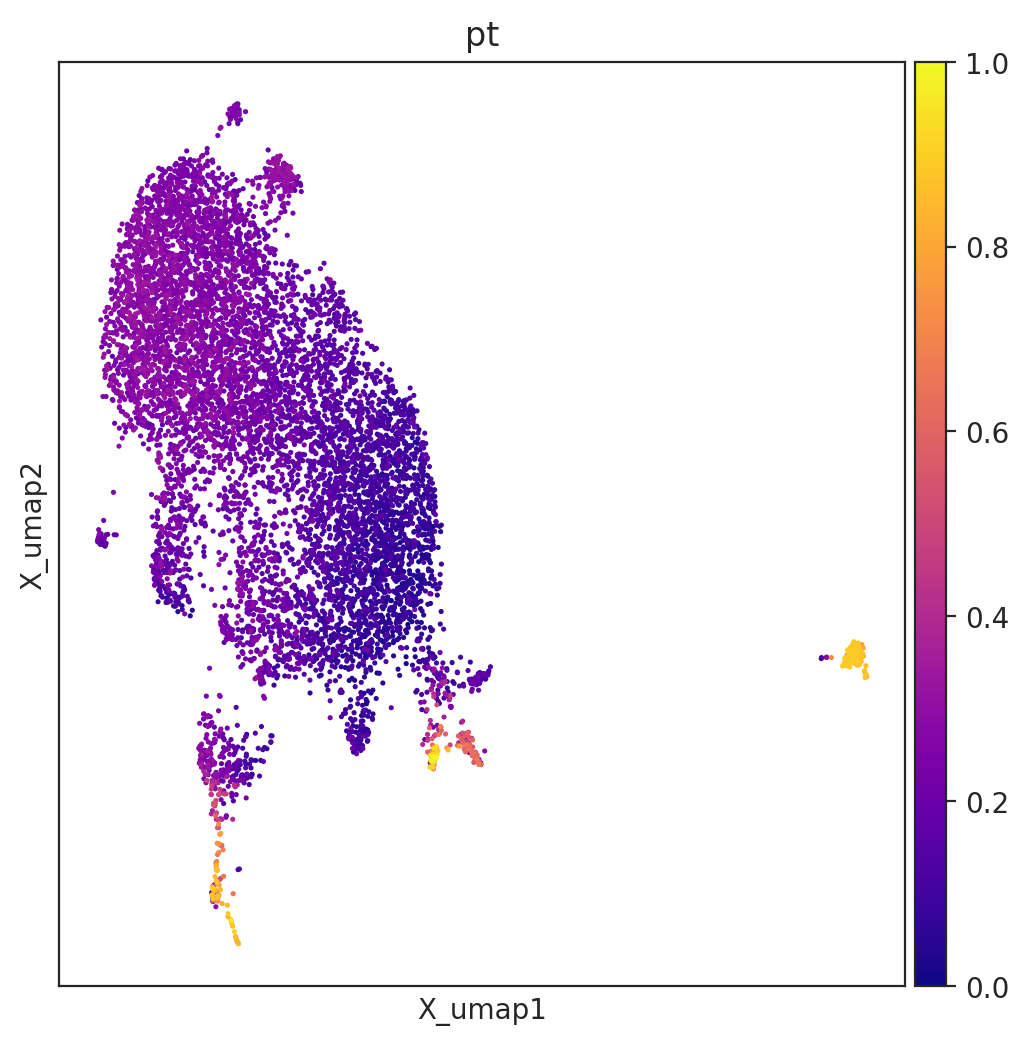

In [24]:
# Visualize pseudotime
fig, ax = plt.subplots(figsize=[6,6])

sc.pl.embedding(adata=oracle.adata, basis=oracle.embedding_name, ax=ax, cmap="plasma",
                color=["pt"])

In [25]:
from celloracle.applications import Gradient_calculator

# Instantiate Gradient calculator object
gradient = Gradient_calculator(oracle_object=oracle, pseudotime_key="pt")

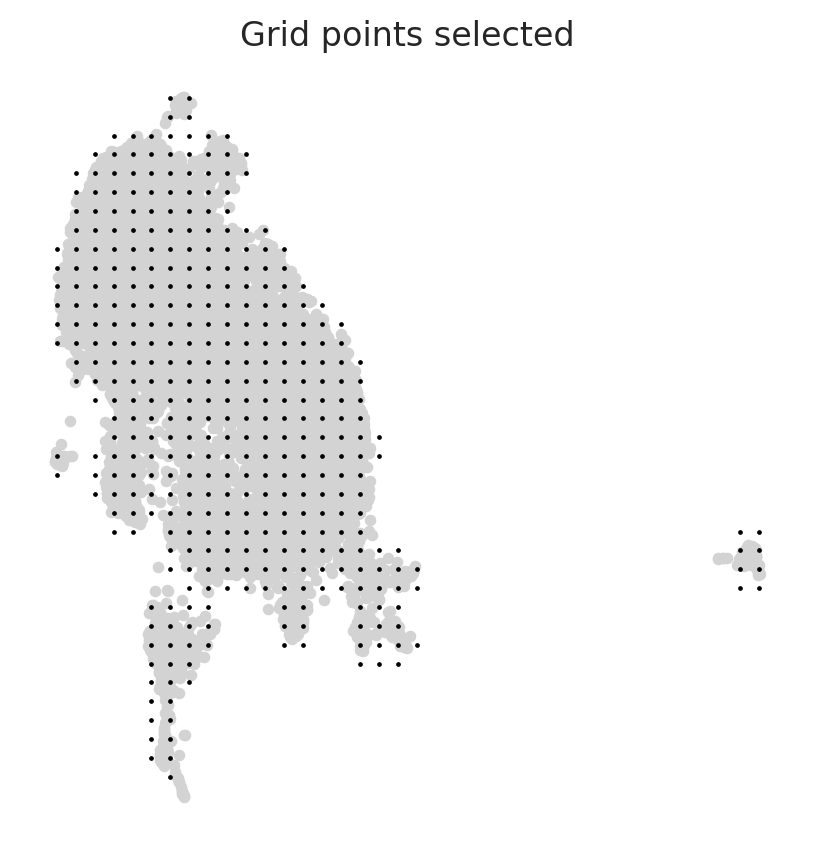

In [26]:
gradient.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)
gradient.calculate_mass_filter(min_mass=min_mass, plot=True)

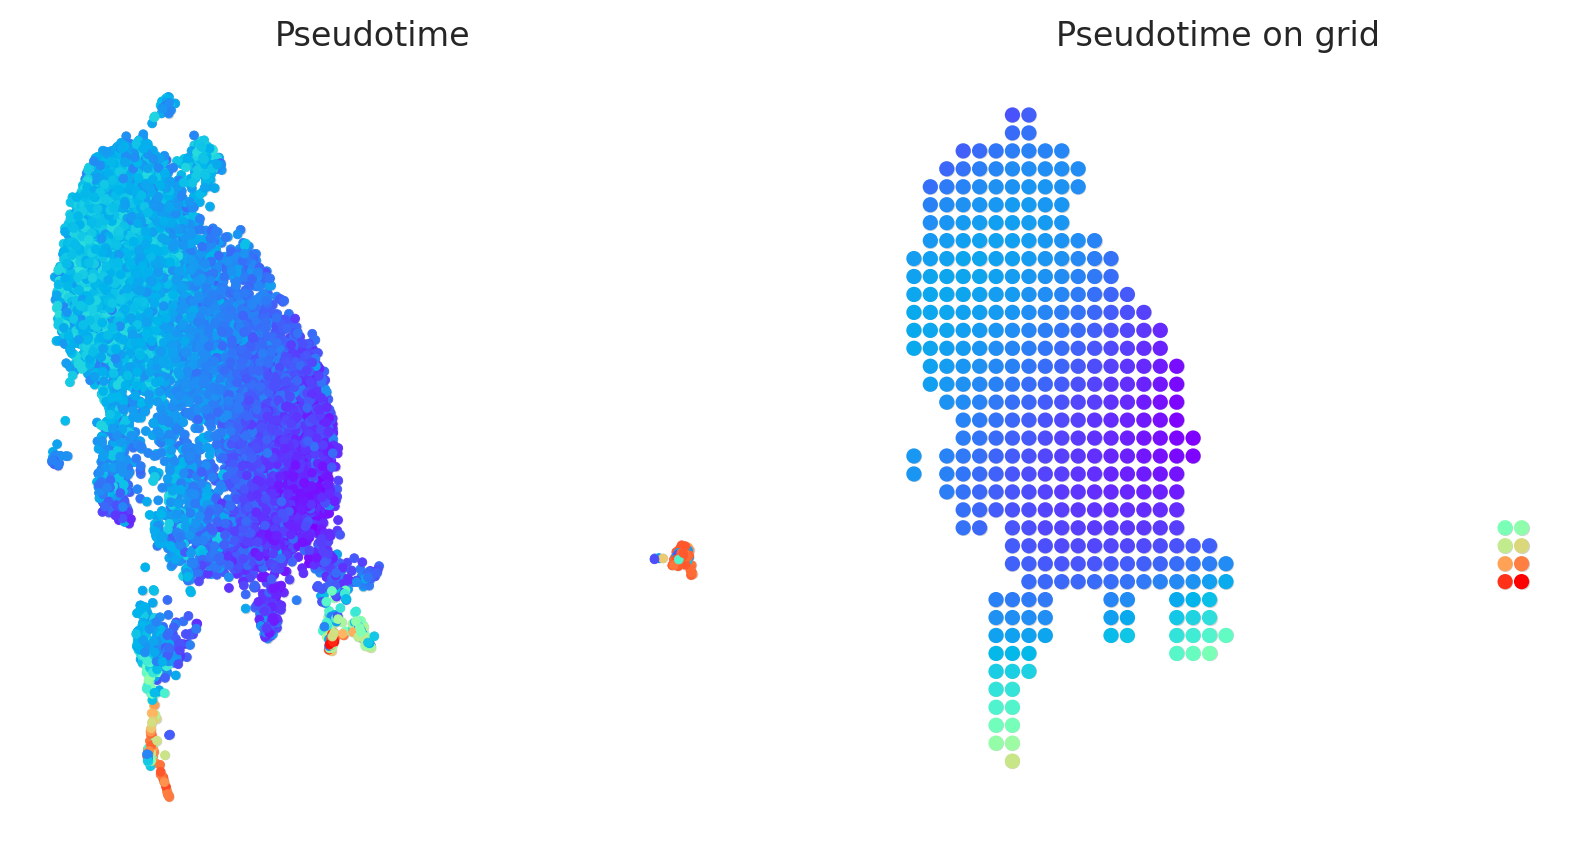

In [27]:
gradient.transfer_data_into_grid(args={"method": "polynomial", "n_poly":3}, plot=True)

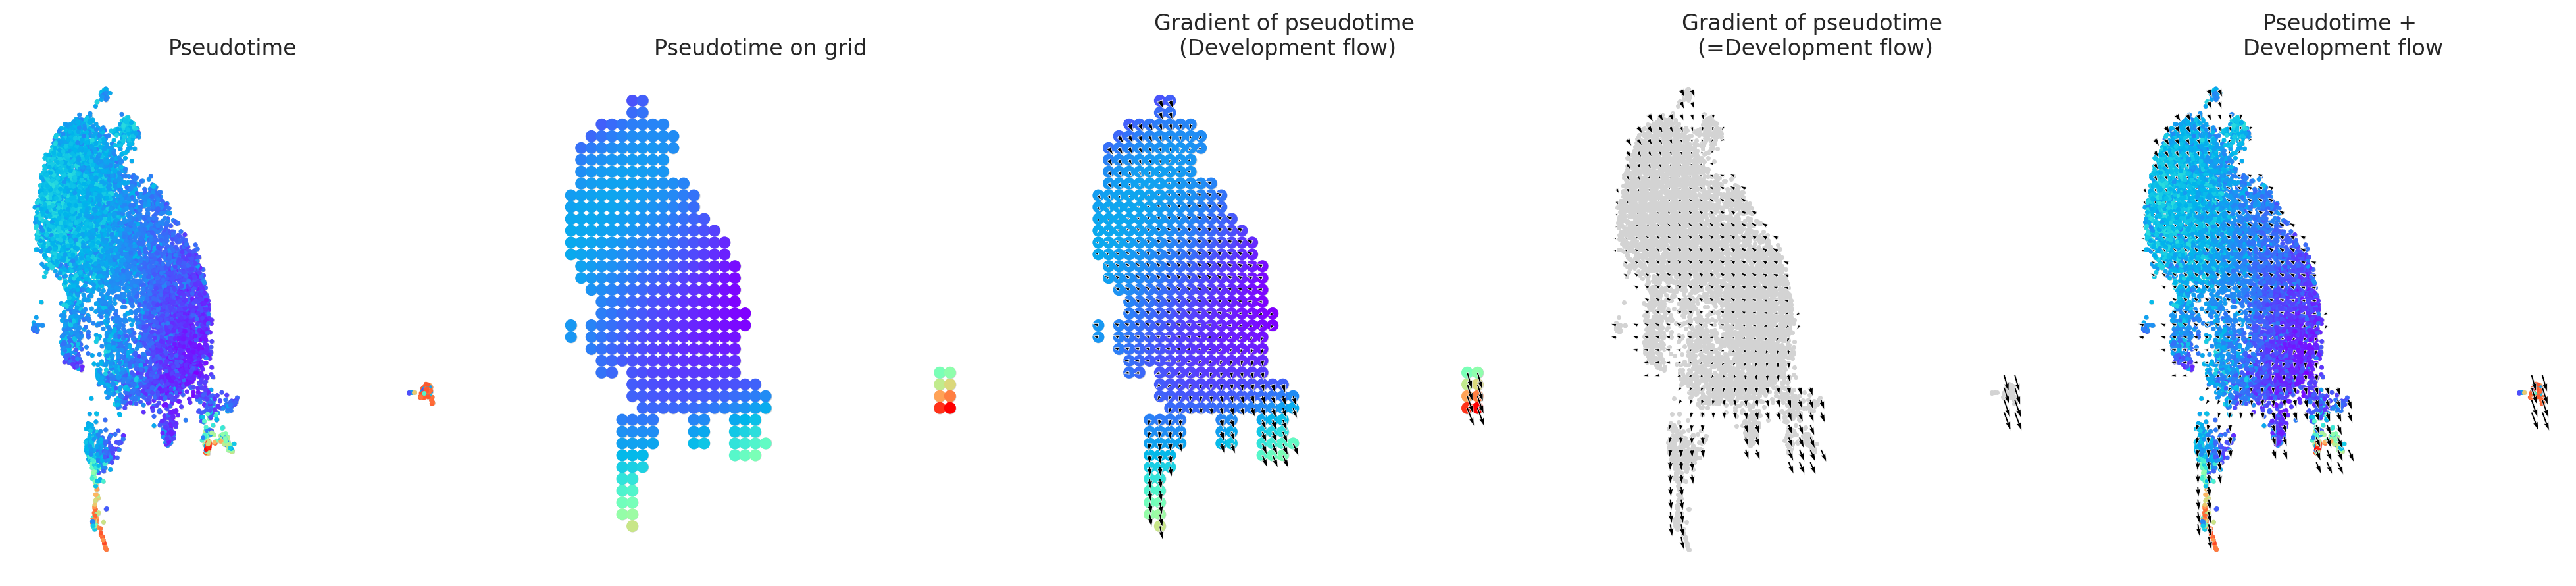

In [28]:
# Calculate graddient
gradient.calculate_gradient()

# Show results
scale_dev = 40
gradient.visualize_results(scale=scale_dev, s=5)

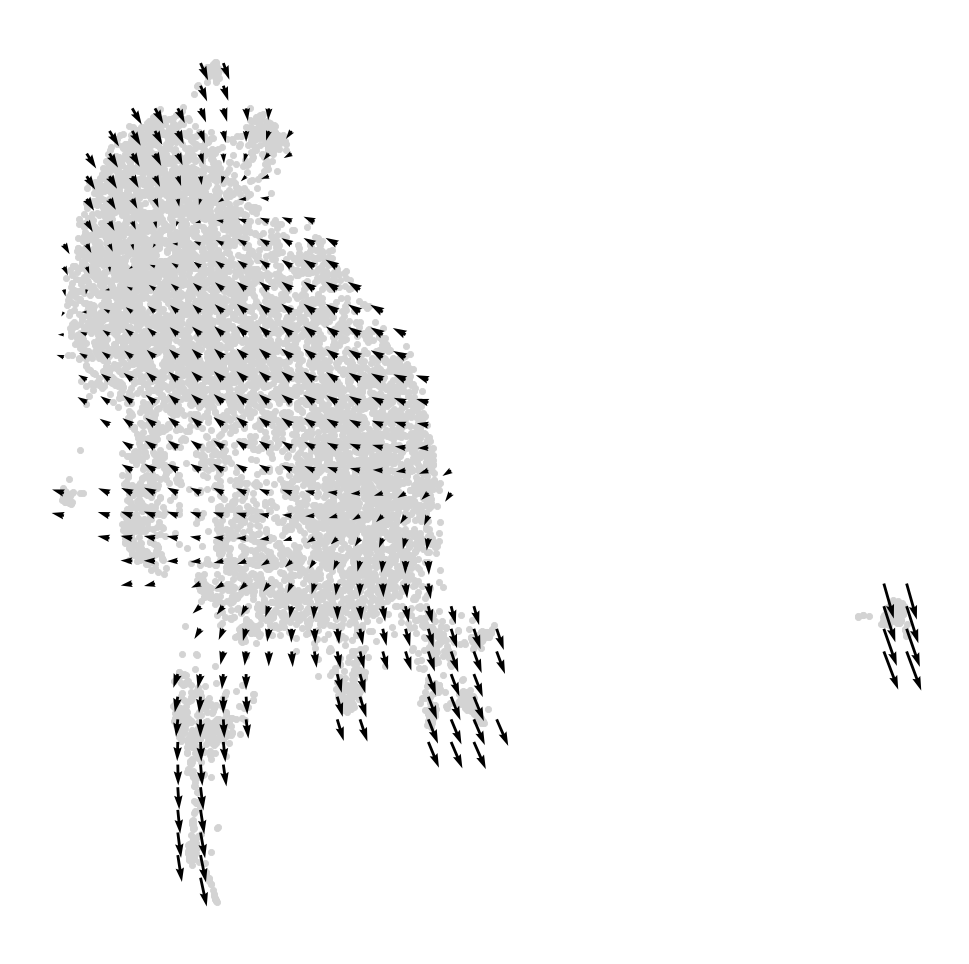

In [29]:
# Visualize results
fig, ax = plt.subplots(figsize=[6, 6])
gradient.plot_dev_flow_on_grid(scale=scale_dev, ax=ax)

In [30]:
gradient.to_hdf5("myeloid.developmentGradient.celloracle.gradient")

In [19]:
gradient = co.load_hdf5("fibroblast.developmentGradient.celloracle.gradient")

In [31]:
from celloracle.applications import Oracle_development_module

# Make Oracle_development_module to compare two vector field
dev = Oracle_development_module()

# Load development flow
dev.load_differentiation_reference_data(gradient_object=gradient)

# Load simulation result
dev.load_perturb_simulation_data(oracle_object=oracle)


# Calculate inner produc scores
dev.calculate_inner_product()
dev.calculate_digitized_ip(n_bins=10)

In [32]:
from celloracle.visualizations.config import CONFIG
CONFIG["cmap_ps"] = "coolwarm"

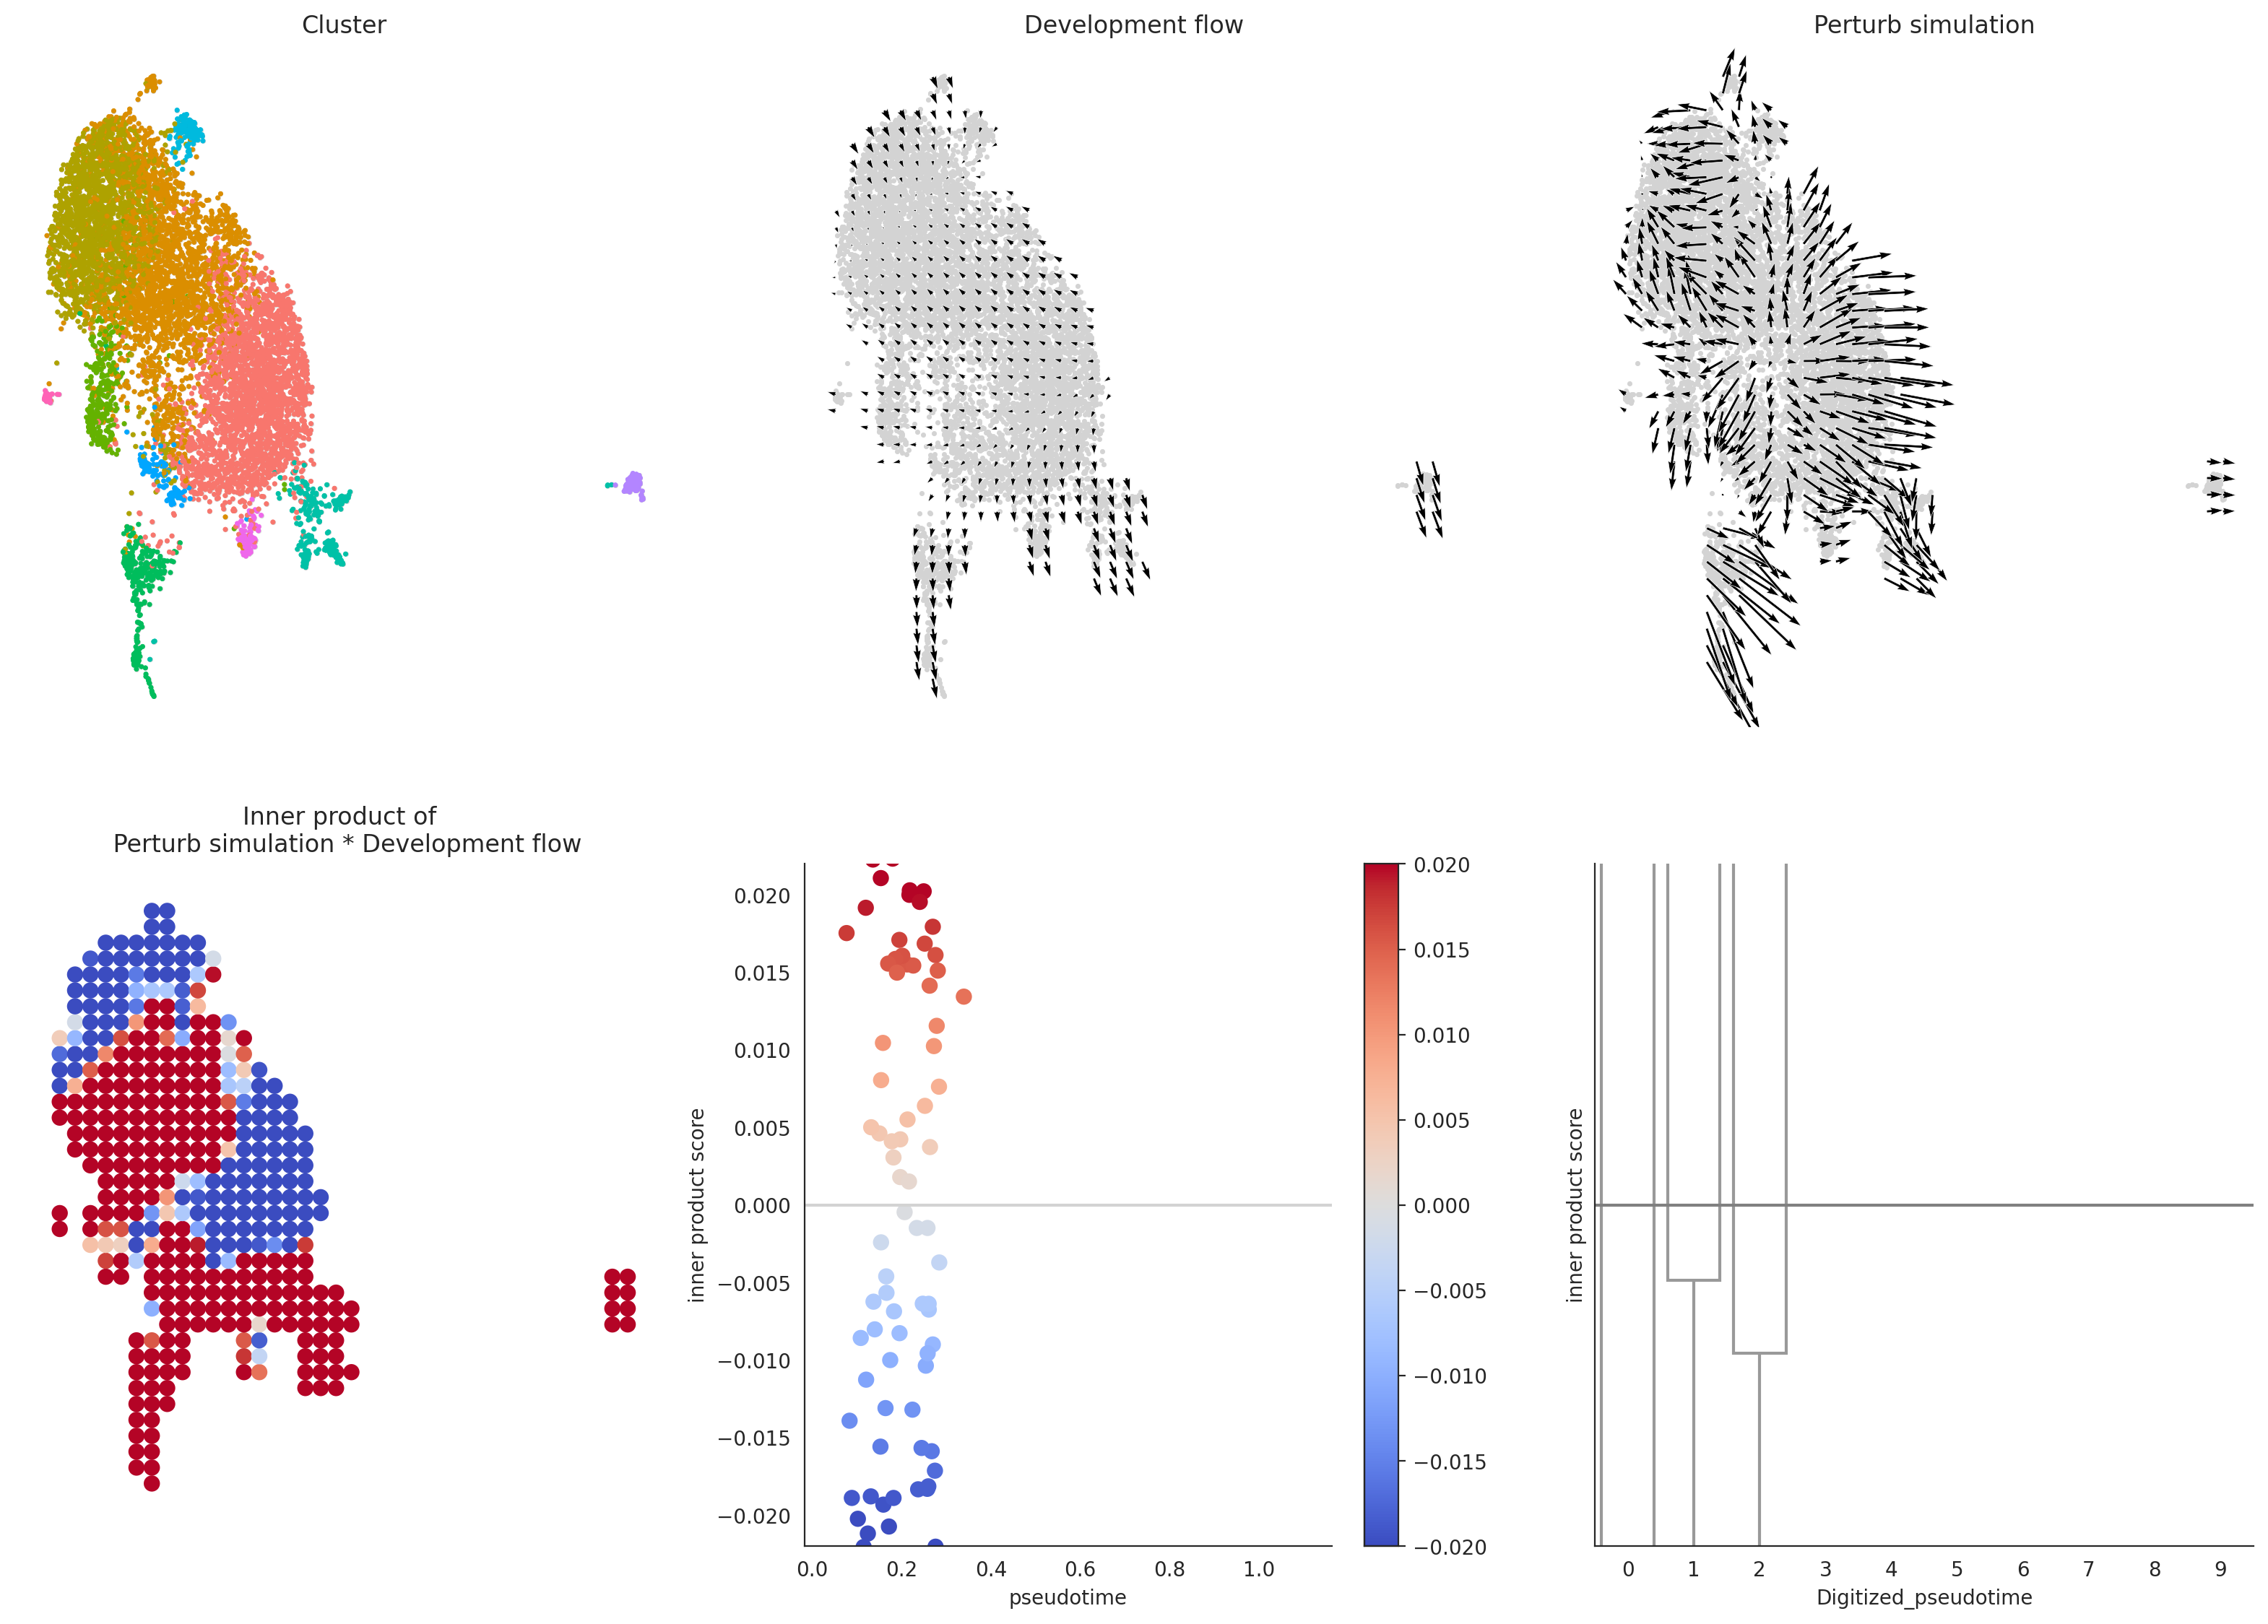

In [33]:
# Let's visualize the results
scale_dev = 40
dev.visualize_development_module_layout_0(s=5,
                                          scale_for_simulation=scale_simulation,
                                          s_grid=50,
                                          scale_for_pseudotime=scale_dev,
                                          vm=0.02)

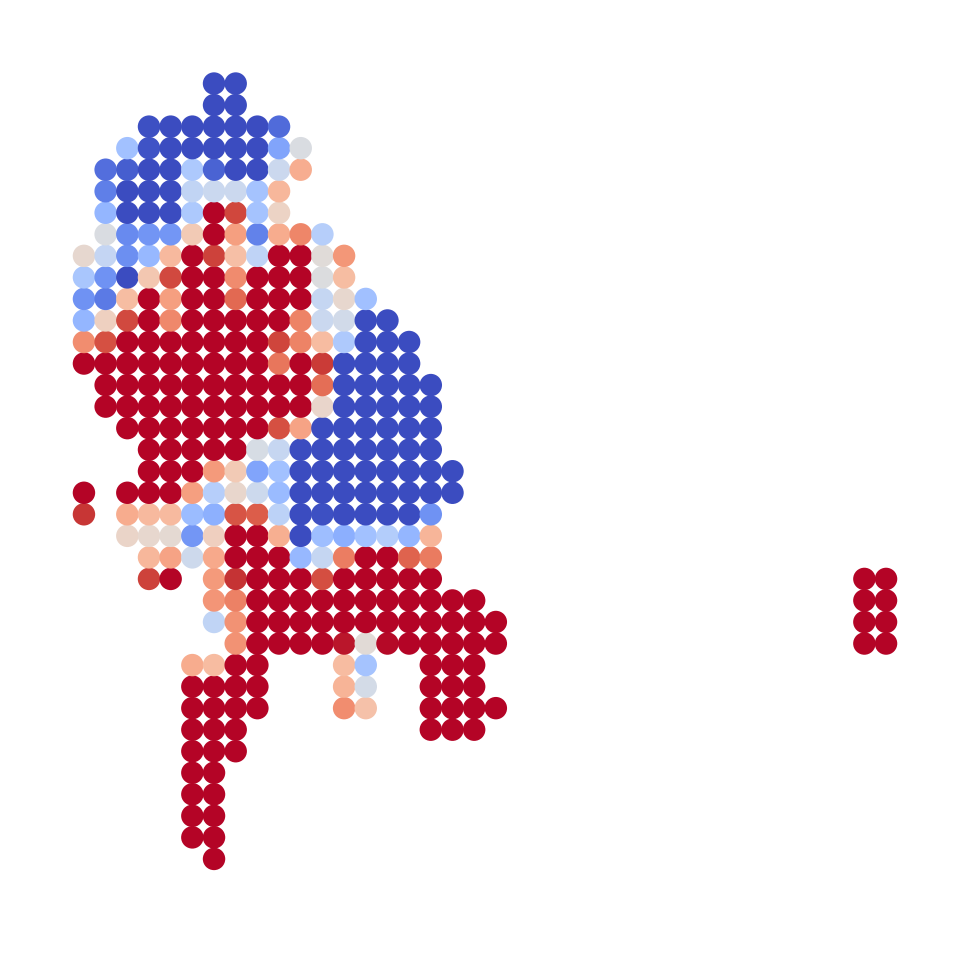

In [36]:
# Show perturbation scores
fig, ax = plt.subplots(figsize=[6, 6])
dev.plot_inner_product_on_grid(vm=0.05, s=50, ax=ax)

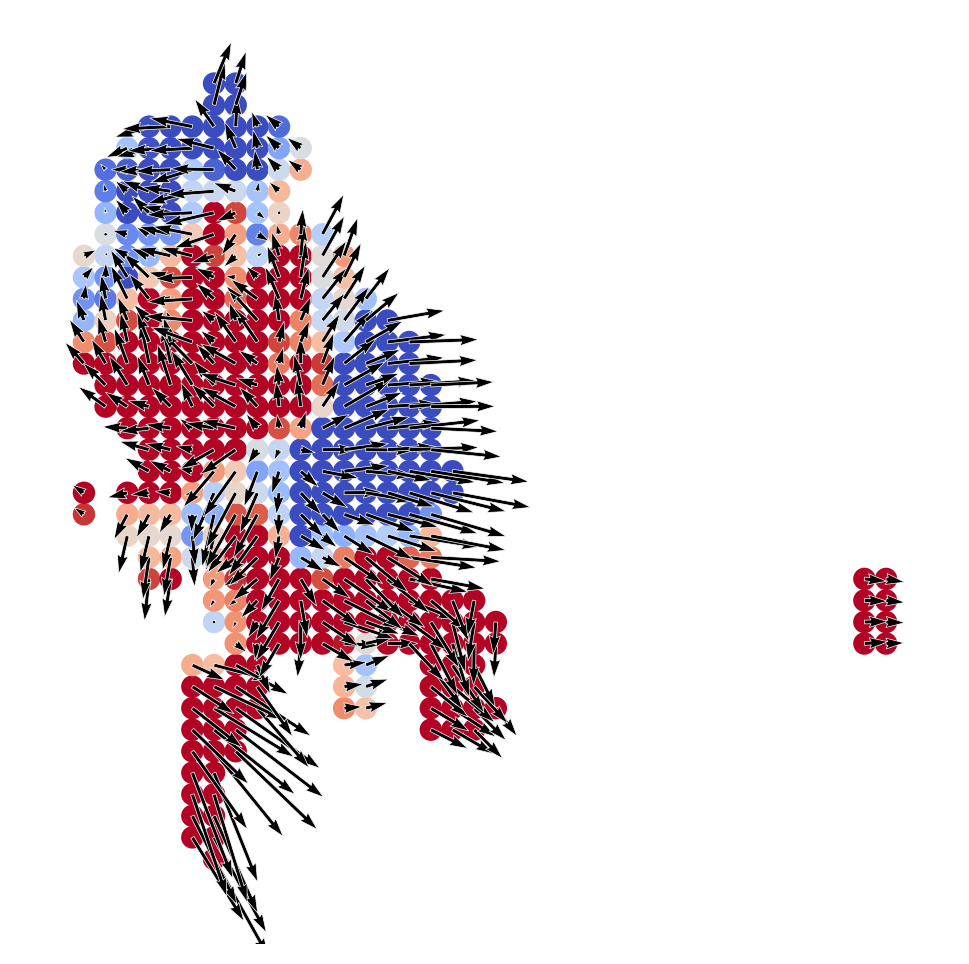

In [37]:
# Show perturbation scores with perturbation simulation vector field
fig, ax = plt.subplots(figsize=[6, 6])
dev.plot_inner_product_on_grid(vm=0.05, s=50, ax=ax)
dev.plot_simulation_flow_on_grid(scale=scale_simulation, show_background=False, ax=ax)
plt.savefig("RUNX1_KO_simulation_vector_field_dot_product.pdf")

In [56]:
import seaborn as sns
sns.set_theme(style="whitegrid")

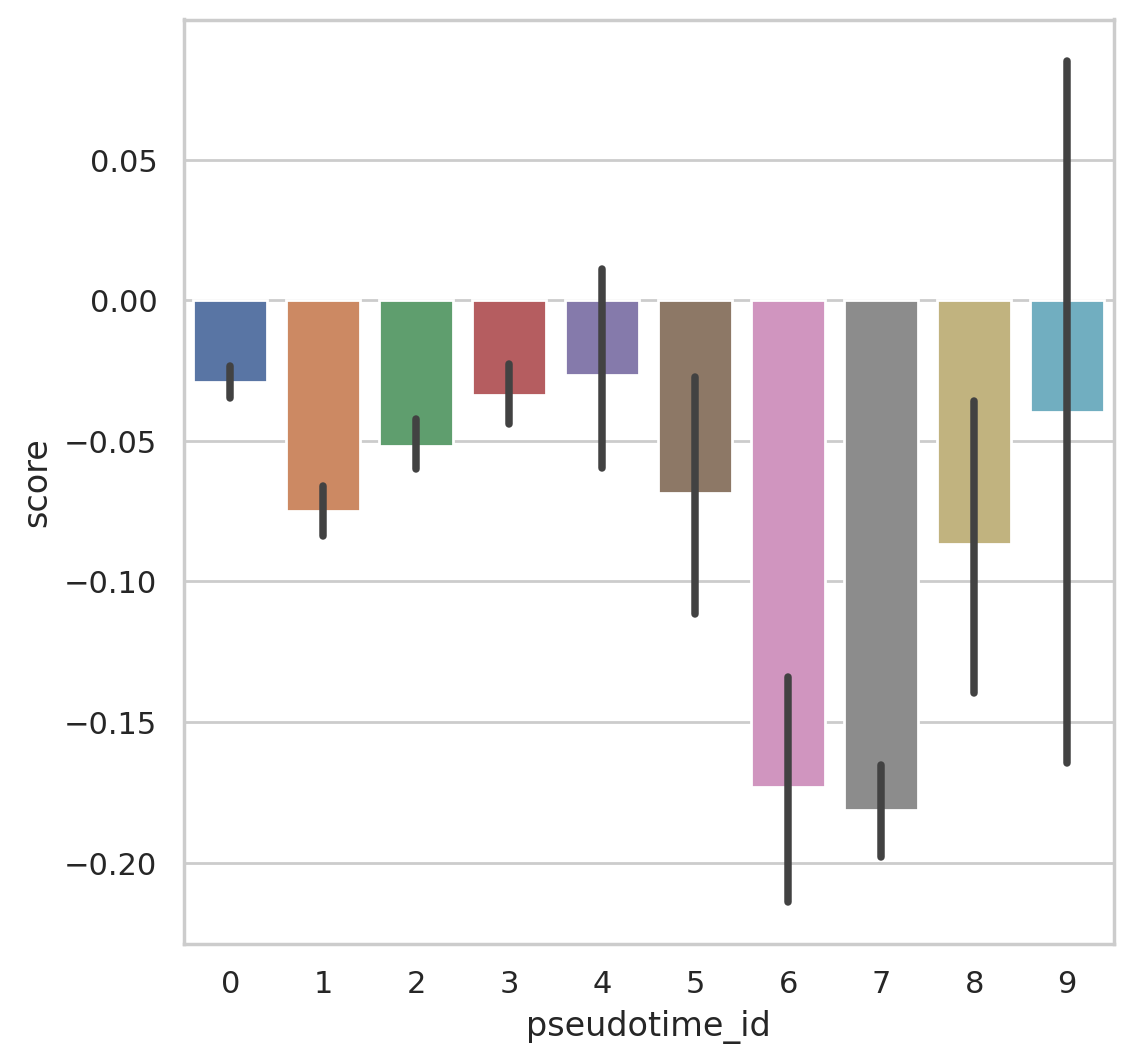

In [57]:
ax = sns.barplot(x="pseudotime_id", y="score", data=dev.inner_product_df)